In [1]:
# import packages
import torchplot as plt
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchmetrics import Accuracy
from tqdm.notebook import tqdm
from pathlib import Path
from opacus.validators import ModuleValidator
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager
import warnings
warnings.simplefilter("ignore")


# define the model
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        DROPOUT = 0.1

        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.Dropout(DROPOUT)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

norm = transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

train_transforms = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        norm,
    ])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    norm,
])

# download the CIFAR_10 dataset from torchvision API to the local directory
train_val_dataset = datasets.CIFAR10(root="./datasets/", train=True, download=False, transform=train_transforms)
test_dataset = datasets.CIFAR10(root="./datasets/", train=False, download=False, transform=test_transforms)

# split the dataset into training, validation and testing sets
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])

# create the dataloader for training, validation and testing sets
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# initialize the model, loss function, optimizer and evaluation metrics
model_resnet = ResNet18()
# optimizer = torch.optim.SGD(model_resnet.parameters(), momentum=0.9, lr=0.01)
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()
accuracy = Accuracy(task="multiclass", num_classes=10)

# train the model
epoch = 90
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device-agnostic setup
accuracy = accuracy.to(device)
model_resnet = model_resnet.to(device)

train_losses = []
val_losses = []
epochs_list = []

for epochs in range(epoch): #I decided to train the model for 50 epochs
    loss_ep = 0
    
    for batch_idx, (data, targets) in enumerate(train_dataloader):
        data = data.to(device)
        targets = targets.to(device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model_resnet(data)
        loss = loss_fn(scores, targets)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
    
    print(f"Epoch {epochs+1} ] Loss : {loss_ep/len(train_dataloader):.6f}")
    
    if (epochs + 1) in [10, 20, 30, 40, 50, 60, 70, 80]:
        train_losses.append(loss_ep / len(train_dataloader))
        
        with torch.no_grad():
            val_loss_ep = 0
            for batch_idx, (data, targets) in enumerate(val_dataloader):
                data = data.to(device)
                targets = targets.to(device)
                scores = model_resnet(data)
                val_loss = loss_fn(scores, targets)
                val_loss_ep += val_loss.item()
            val_losses.append(val_loss_ep / len(val_dataloader))
        
        epochs_list.append(epochs + 1)
        
        # Save the model at the desired epoch
        torch.save(model_resnet.state_dict(), f"model_epoch_{epochs+1}.pth")
    
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for batch_idx, (data, targets) in enumerate(val_dataloader):
            data = data.to(device)
            targets = targets.to(device)
            ## Forward Pass
            scores = model_resnet(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(f"Epoch {epochs+1} ] Accuracy : {float(num_correct) / float(num_samples) * 100:.2f}%")

dest = Path("figures")
dest.mkdir(parents=True, exist_ok=True)
dest1 = dest / "resnet_cifar10_wt_diff_batches.png"
plt.plot(epochs_list, train_losses, label='Train Loss')
plt.plot(epochs_list, val_losses, label='Val Loss')
plt.xlabel('# Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig(dest1)
plt.show()

KeyboardInterrupt: 

In [2]:
MAX_GRAD_NORM = 1.2
EPSILON = 10
DELTA = 1e-5
EPOCHS = 30
LR = 1e-3 # replace with 0.2
BATCH_SIZE = 32
MAX_PHYSICAL_BATCH_SIZE = 32

norm = transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
train_transforms = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.ToTensor(), norm,])
test_transforms = transforms.Compose([transforms.ToTensor(), norm,])

# download the CIFAR_10 dataset from torchvision API to the local directory
train_val_dataset = datasets.CIFAR10(root="./datasets/", train=True, download=False, transform=train_transforms)
test_dataset = datasets.CIFAR10(root="./datasets/", train=False, download=False, transform=test_transforms)

# create the dataloader for training, validation and testing sets
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# initialize the model
model = models.resnet18(num_classes=10)
model = model.to(device)

# check and fix the layer incompatibility issues 
errors = ModuleValidator.validate(model, strict=False)
(errors[-5:])
model = ModuleValidator.fix(model)
ModuleValidator.validate(model, strict=False)

# set the optimizer and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

# define a util function to calculate the accuracy
def accuracy(preds, labels):
    return (preds == labels).mean()

# attach the privacy engine initialized with the privacy hyperparameters defined earlier
privacy_engine = PrivacyEngine()

In [3]:
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Using sigma={optimizer.noise_multiplier} and C={MAX_GRAD_NORM}")

Using sigma=0.453338623046875 and C=1.2


In [4]:
def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []
    
    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images, target) in enumerate(memory_safe_data_loader):   
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            # measure accuracy and record loss
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()
            optimizer.step()

            if (i+1) % 200 == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                print(
                    f"\tTrain Epoch: {epoch} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    f"Acc@1: {np.mean(top1_acc) * 100:.6f} "
                    f"(ε = {epsilon:.2f}, δ = {DELTA})"
                )
                
    return model

In [5]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)

In [9]:
best_acc = 0.0
for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
    model = train(model, train_loader, optimizer, epoch + 1, device)

    # test the network on test data and save the best model
    top1_acc = test(model, test_dataloader, device)

    if top1_acc > best_acc:
        best_acc = top1_acc
        torch.save(model.state_dict(), f"resnet_cifar10_eps_{EPSILON}.pth")


Epoch:   0%|          | 0/30 [00:00<?, ?epoch/s]

	Train Epoch: 1 	Loss: 2.300409 Acc@1: 14.429962 (ε = 2.89, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.271677 Acc@1: 15.576773 (ε = 3.27, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.249775 Acc@1: 16.260741 (ε = 3.50, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.235318 Acc@1: 16.738941 (ε = 3.66, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.222967 Acc@1: 17.340060 (ε = 3.79, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.213661 Acc@1: 17.764591 (ε = 3.90, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.202575 Acc@1: 18.355174 (ε = 3.99, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.194030 Acc@1: 18.848808 (ε = 4.07, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.182669 Acc@1: 19.400490 (ε = 4.14, δ = 1e-05)
	Train Epoch: 1 	Loss: 2.174199 Acc@1: 19.800762 (ε = 4.21, δ = 1e-05)
	Test set:Loss: 2.040468 Acc: 25.249601 
	Train Epoch: 2 	Loss: 2.083283 Acc@1: 23.046103 (ε = 4.29, δ = 1e-05)
	Train Epoch: 2 	Loss: 2.093376 Acc@1: 22.834250 (ε = 4.35, δ = 1e-05)
	Train Epoch: 2 	Loss: 2.100100 Acc@1: 22.494610 (ε = 4.40, δ = 1e-05)
	Train Epoch: 2 	Loss: 2.094087 Acc@

In [10]:
best_acc

0.3922723642172524

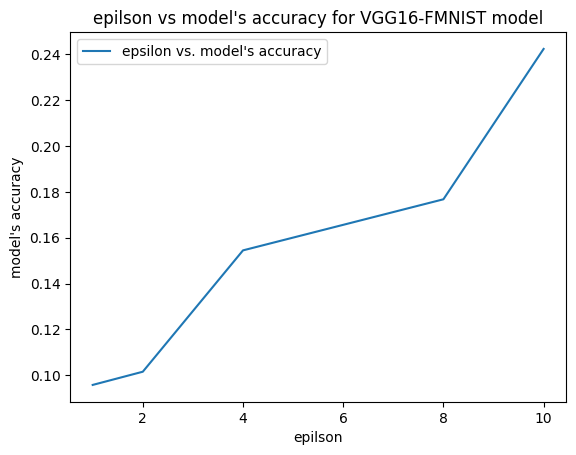

In [6]:
eps = [1, 2, 4, 8, 10]
acc = [0.09581, 0.10157, 0.15450, 0.17678, 0.24237]
plt.plot(eps, acc, label="epsilon vs. model's accuracy")
plt.xlabel('epilson')
plt.ylabel("model's accuracy")
plt.title("epilson vs model's accuracy for VGG16-FMNIST model")
plt.legend()
plt.savefig("eps_acc_vgg16_fmnist.png")
plt.show()

In [21]:
import torch
import torchvision.models as models

def load_model(model_path):
    model = models.resnet18(num_classes=10).to(device)  # Replace DEVICE with your target device
    saved_state_dict = torch.load(model_path)

    # Check for missing and unexpected keys
    missing_keys = []
    unexpected_keys = []
    for key in saved_state_dict.keys():
        if key not in model.state_dict():
            unexpected_keys.append(key)
    for key in model.state_dict().keys():
        if key not in saved_state_dict:
            missing_keys.append(key)

    # Fix the missing and unexpected keys
    for missing_key in missing_keys:
        saved_state_dict[missing_key] = model.state_dict()[missing_key]
    for unexpected_key in unexpected_keys:
        del saved_state_dict[unexpected_key]

    # Load the modified state dictionary
    model.load_state_dict(saved_state_dict)

    return model

# Usage example
model_path = Path("saved_dp_models/resnet_cifar10_eps_1.pth")  # Replace with the actual path to your saved model file
resnet_model = load_model(model_path)
print("Loaded model:", model_path)

Loaded model: saved_dp_models\resnet_cifar10_eps_1.pth
